In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../src')
from lda import GibbsLDA
from sim import make_dataset
from slda import GibbsSLDA
from util import map_labels, show_dataset

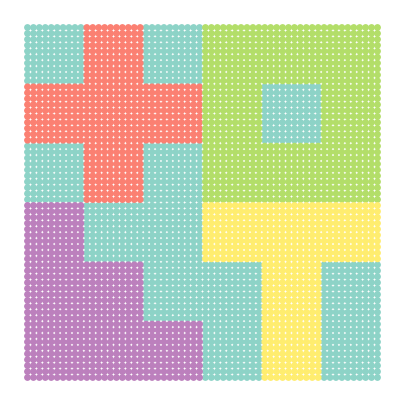

In [2]:
data, labels = make_dataset('polygons', 10, n_features=100, wiggle=0., mix=0., return_tensor=False)
show_dataset(data, labels)

SLDA: 100%|██████████| 200/200 [00:48<00:00,  4.16it/s]


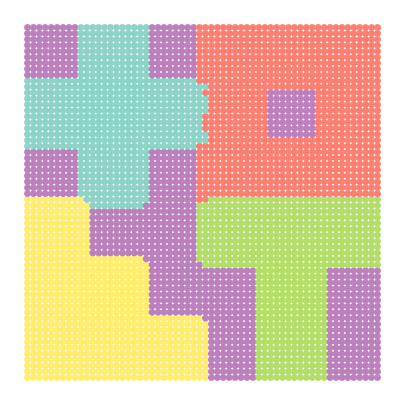

In [8]:
model = GibbsSLDA(word_scale=.4)
labels = model.fit_predict(data)
show_dataset(data, labels)

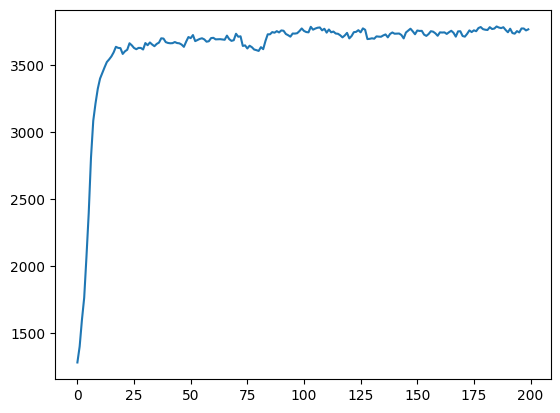

In [7]:
x = np.arange(len(model.likelihood_log))
plt.plot(x, model.likelihood_log)
plt.show()

In [342]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

def activation(act='relu', **kwargs):
    if act == 'relu':
        return nn.ReLU(**kwargs)
    elif act == 'prelu':
        return nn.PReLU(**kwargs)
    elif act == 'softplus':
        return nn.Softplus(**kwargs)
    elif act == 'sigmoid':
        return nn.Sigmoid(**kwargs)
    elif act == 'tanh':
        return nn.Tanh(**kwargs)
    
    raise NotImplementedError(f'Activation "{act}" not supported.')

def layer(input_dim, output_dim, bias=True, batch_norm=False, act='relu', dropout=0.):
    yield nn.Linear(input_dim, output_dim, bias=bias)

    if batch_norm:
        yield nn.BatchNorm1d(output_dim)

    if act is not None:
        yield activation(act)

    if dropout > 0.:
        yield nn.Dropout(dropout)

def mlp(layers, bias=True, final_bias=True, batch_norm=False, final_norm=False, act='relu', final_act=None, dropout=0., final_drop=0.):
    n_layers = len(layers)
    net = []

    for i in range(1, n_layers):
        if i < n_layers - 1:
            yield from layer(layers[i - 1], layers[i], bias, batch_norm, act, dropout)
        else:
            yield from layer(layers[i - 1], layers[i], final_bias, final_norm, final_act, final_drop)

class MLP(nn.Module):
    def __init__(self, layers, bias=True, final_bias=True, batch_norm=False, final_norm=False, act='relu', final_act=None, dropout=0., final_drop=0.):
        super().__init__()

        self.net = nn.Sequential(*list(mlp(layers, bias, final_bias, batch_norm, final_norm, act, final_act, dropout, final_drop)))

    def forward(self, x):
        y = self.net(x)

        return y

class Encoder(nn.Module):
    def __init__(self, h_layers, g_layers, u_layers, f_layers):
        super().__init__()

        self.h_net = MLP(h_layers, batch_norm=True, act='prelu')
        self.g_net = MLP(g_layers, batch_norm=True, act='prelu')
        self.u_net = MLP(u_layers, batch_norm=True, act='prelu')
        self.f_net = MLP(f_layers, final_bias=False, batch_norm=True, act='prelu')

    def forward(self, data):        
        h, u = self.h_net(data), self.u_net(data)
        U, K = u[1:].sum(0)[None].repeat(100, 1), 1
        H = torch.zeros((100, h.shape[-1]))
        H[0, :] = h[0]
        G = self.g_net(H[0])
        Gk = torch.zeros((100, G.shape[-1]))
        c = torch.zeros(data.shape[0], dtype=torch.int32)
        q = torch.zeros((data.shape[0], 100))

        for n in range(1, data.shape[0]):
            U = U - u[n]

            Gk[:K + 1] = G + self.g_net(H[:K + 1] + h[n]) - self.g_net(H[:K + 1])
            q[n, :K + 1] = self.f_net(torch.hstack([Gk[:K + 1], U[:K + 1]])).flatten()
            c[n] = torch.multinomial(q[n, :K + 1].exp(), 1)
            # c[n] = q[n, :K + 1].argmax()

            if c[n] == K:
                K += 1

            G = G - self.g_net(H[c[n]]) + self.g_net(H[c[n]] + h[n])
            H = H + torch.vstack([torch.zeros((c[n], h.shape[-1])), h[n][None], torch.zeros((H.shape[0] - c[n] - 1, h.shape[-1]))])

        return c, q[:, :K + 1]
    
class NCP(nn.Module):
    def __init__(self, h_layers, g_layers, u_layers, f_layers):
        super().__init__()

        self.encoder = Encoder(h_layers, g_layers, u_layers, f_layers)

        self.loss_log = []

    def train(self, data, n_steps=100, learning_rate=1e-4):
        optimizer = torch.optim.Adam(self.encoder.parameters(), lr=learning_rate)
        x = torch.arange(data.shape[0])

        for i in tqdm(range(n_steps)):
            l = 0
            for _ in range(1):
                idx = torch.randperm(data.shape[0])
                c, logprobs = self.encoder(data[idx])
                loss = -logprobs[x, c].mean()
                loss.backward()
                l += loss.item()
            self.loss_log.append(l)
            optimizer.step()
            optimizer.zero_grad()

        return self

In [343]:
h_layers = [data.shape[-1] - 3, 75]
g_layers = [75, 25]
u_layers = [data.shape[-1] - 3, 75, 25]
f_layers = [50, 25, 25, 1]

model = NCP(h_layers, g_layers, u_layers, f_layers).train(data[:, 3:])
c, _ = model.encoder(data[:, 3:])
show_dataset(data, c)
plt.show()
x = np.arange(len(model.loss_log))
plt.plot(x, model.loss_log)
plt.show()

  2%|▏         | 2/100 [00:04<03:43,  2.28s/it]


KeyboardInterrupt: 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import argparse
import time
import os
import torch

def main(args):
    model = args.model
    params = get_parameters(model)
    params['device'] = torch.device("cuda:0" if args.cuda else "cpu")
    
    print(params['device'])

    
    dpmm = NeuralClustering(params).to(params['device'])
    data_generator = get_generator(params)
    

    #define containers to collect statistics
    losses= []       # NLLs    
    accs =[]         # Accuracy of the classification prediction
    perm_vars = []   # permutation variance

    
    it=0      # iteration counter
    learning_rate = 1e-4
    weight_decay = 0.01
    optimizer = torch.optim.Adam( dpmm.parameters() , lr=learning_rate, weight_decay = weight_decay)
    
    perms = 6  # Number of permutations for each mini-batch. 
               # In each permutation, the order of the datapoints is shuffled.         
               
    batch_size = args.batch_size
    max_it = args.iterations
    
    

    if params['model'] == 'Gauss2D':
        if not os.path.isdir('saved_models/Gauss2D'):
            os.makedirs('saved_models/Gauss2D')
        if not os.path.isdir('figures/Gauss2D'):
            os.makedirs('figures/Gauss2D')


    elif params['model'] == 'MNIST':
        if not os.path.isdir('saved_models/MNIST'):
            os.makedirs('saved_models/MNIST')
        if not os.path.isdir('figures/MNIST'):
            os.makedirs('figures/MNIST')
    
    
    
    
    end_name = params['model']    
    learning_rates = {1200:5e-5, 2200:1e-5}
    
    
    
      
    t_start = time.time()
    itt = it
    while True:
                
            it += 1
    
            if it == max_it:
                break
            
            dpmm.train()
                
            if it % 100 == 0:
                if 'fname' in vars():
                    os.remove(fname)
                dpmm.params['it'] = it
                fname = 'saved_models/'+ end_name + '/'+ end_name +'_' + str(it) + '.pt'            
                torch.save(dpmm,fname)
    
                
            if it in learning_rates:            
                optimizer = torch.optim.Adam( dpmm.parameters() , lr=learning_rates[it], weight_decay = weight_decay)
    
    
            data, cs, clusters, K = data_generator.generate(None, batch_size)    
            N=data.shape[1]
            
            loss_values = np.zeros(perms)
            accuracies = np.zeros([N-1,perms])
            
            
            # The memory requirements change in each iteration according to the random values of N and K.
            # If both N and K are big, an out of memory RuntimeError exception might be raised.
            # When this happens, we capture the exception, reduce the batch_size to 3/4 of its value, and try again.
            
            while True:
                try:
    
                    loss = 0        
                    
                    for perm in range(perms):
                        arr = np.arange(N)
                        np.random.shuffle(arr)   # permute the order in which the points are queried
                        cs = cs[arr]
                        data= data[:,arr,:]    
            
                        cs = relabel(cs)    # this makes cluster labels appear in cs[] in increasing order
                                
            
                        this_loss=0                        
                        dpmm.previous_n=0            
                        
                        for n in range(1,N):                
                        # points up to (n-1) are already assigned, the point n is to be assigned
                        
                            logprobs  = dpmm(data,cs,n)                
                            c = cs[n] 
                            accuracies[n-1, perm] = np.sum(np.argmax(logprobs.detach().to('cpu').numpy(),axis=1)==c)/logprobs.shape[0]            
                            
                            
                            this_loss -= logprobs[:,c].mean()
            
                                    
                        this_loss.backward()    # this accumulates the gradients for each permutation
                        loss_values[perm] = this_loss.item()/N
                        loss += this_loss
                        
                    
                    perm_vars.append(loss_values.var())
                    losses.append(loss.item()/N)
                    accs.append(accuracies.mean())
                    
                    optimizer.step()      # the gradients used in this step are the sum of the gradients for each permutation 
                    optimizer.zero_grad()    
            
    
                    print('{0:4d}  N:{1:2d}  K:{2}  Mean NLL:{3:.3f}   Mean Acc:{4:.3f}   Mean Permutation Variance: {5:.7f}  Mean Time/Iteration: {6:.1f}'\
                          .format(it, N, K , np.mean(losses[-50:]), np.mean(accs[-50:]), np.mean(perm_vars[-50:]), (time.time()-t_start)/(it - itt)    ))    
    
                    break
    
                except RuntimeError:
                    bsize = int(.75*data.shape[0])
                    if bsize > 2:
                        print('RuntimeError handled  ', 'N:', N, ' K:', K, 'Trying batch size:', bsize)
                        data = data[:bsize,:,:]
                    else:
                        break

In [353]:
x_dim = data[:, 3:].shape[-1]
h_dim = 256
g_dim = 512
H = 128

cs = np.zeros(data.shape[0], dtype=np.int32)

model = NCP(data[:, 3:].shape[-1], h_dim, g_dim, H).fit(data[:, 3:], cs)

100%|██████████| 100/100 [13:12<00:00,  7.93s/it]


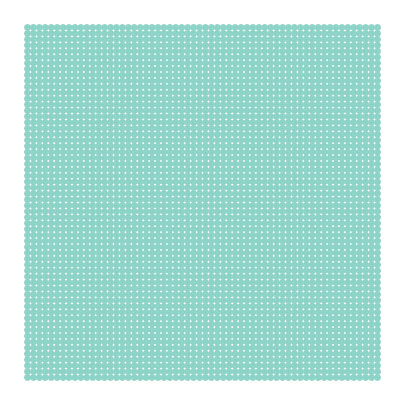

In [355]:
c = [0]

for i in range(1, data.shape[0]):
    logprobs = model(data[:, 3:], cs, i)
    c.append(logprobs.argmax().item())

show_dataset(data, np.array(c))

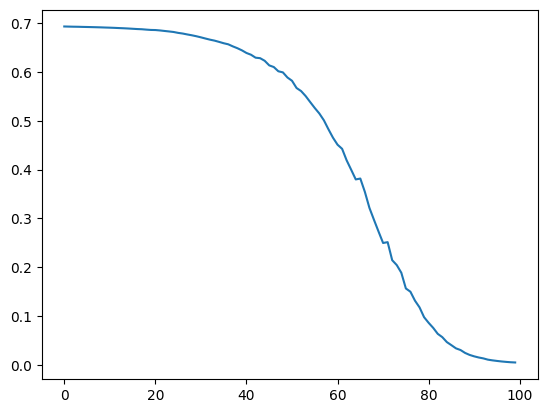

In [354]:
x = np.arange(len(model.loss_log))
plt.plot(x, model.loss_log)
plt.show()

In [61]:
def featurize(data):
    sections = np.unique(data[:, 0])
    features = []

    for s in sections:
        section = data[data[:, 0] == s]
        proximity = cdist(section[:, 1:3], section[:, 1:3], 'euclidean')
        scale = np.sort(proximity, -1)[:, 1:17].mean(-1)
        # gaussian0 = np.exp(-proximity/(2*(.1*scale)**2))/np.sqrt(2*np.pi*(.1*scale)**2)
        gaussian1 = np.exp(-proximity**2/(2*(.5*scale)**2))/np.sqrt(2*np.pi*(.5*scale)**2)
        gaussian2 = np.exp(-proximity**2/(2*(1.*scale)**2))/np.sqrt(2*np.pi*(1.*scale)**2)
        features.append(np.hstack([gaussian1@section[:, 3:], gaussian2@section]))

    features = np.vstack(features)

    return features

def distribute(data, n_documents=None):
    sections = np.unique(data[:, 0])
    documents = []

    for s in sections:
        section = data[data[:, 0] == s]
        n_samples = section.shape[0]

        if n_documents is None:
            n_documents = n_samples//4

        idx = np.random.permutation(n_samples)[:n_documents]
        locations = section[idx, :3]
        proximity = cdist(locations[:, 1:], locations[:, 1:], 'sqeuclidean')
        scale = np.sort(proximity, -1)[:, 1:17].mean(-1)
        documents.append(np.hstack([locations, 4*scale[None].T]))

    documents = np.vstack(documents)

    return documents

SLDA: 100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


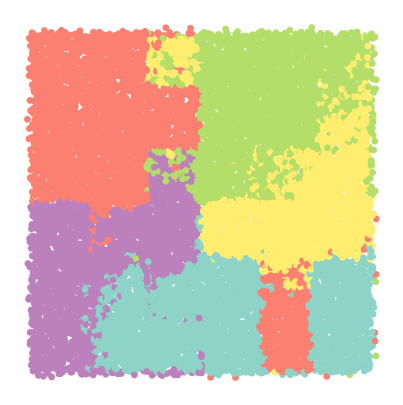

In [62]:
model = SLDA()
model._featurize = featurize
model._distribute = distribute
topics = model.fit_predict(data, n_steps=100, burn_in=75)
topics = map_labels(labels, topics)
show_dataset(data, topics)

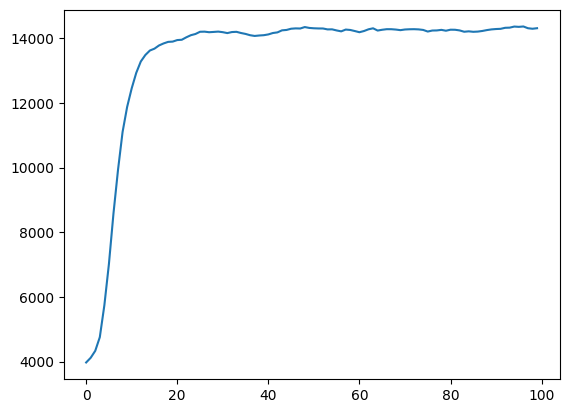

In [60]:
import numpy as np

x = np.arange(len(model.likelihood_log))
plt.plot(x, model.likelihood_log)
plt.show()